In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import pickle
import sqlite3
import datetime as dt
import matplotlib.style as style
import matplotlib.patches as mpatches
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# pickle model for flask app
from sklearn.externals import joblib

/Users/yt/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
con = sqlite3.connect("FPA_FOD_20170508.sqlite")
cur = con.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('spatial_ref_sys',), ('spatialite_history',), ('sqlite_sequence',), ('geometry_columns',), ('spatial_ref_sys_aux',), ('views_geometry_columns',), ('virts_geometry_columns',), ('geometry_columns_statistics',), ('views_geometry_columns_statistics',), ('virts_geometry_columns_statistics',), ('geometry_columns_field_infos',), ('views_geometry_columns_field_infos',), ('virts_geometry_columns_field_infos',), ('geometry_columns_time',), ('geometry_columns_auth',), ('views_geometry_columns_auth',), ('virts_geometry_columns_auth',), ('sql_statements_log',), ('SpatialIndex',), ('ElementaryGeometries',), ('KNN',), ('Fires',), ('idx_Fires_Shape',), ('idx_Fires_Shape_node',), ('idx_Fires_Shape_rowid',), ('idx_Fires_Shape_parent',), ('NWCG_UnitIDActive_20170109',)]


In [38]:
test_df = pd.read_sql_query("SELECT FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE, \
                       CONT_DOY-DISCOVERY_DOY AS DAYS, STAT_CAUSE_CODE, STAT_CAUSE_DESCR FROM Fires", con)

In [39]:
test_df[(test_df['DAYS']<0) | (test_df['DAYS']>150)]

,FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,DAYS,STAT_CAUSE_CODE,STAT_CAUSE_DESCR
6473,141,2005,364,3.0,0.30,B,33.576667,-108.729167,NM,-361.0,3.0,Smoking
6712,BEAVER DAM,2005,364,1.0,3.60,B,30.985556,-89.129444,MS,-363.0,7.0,Arson
6713,WEDGEWORTH,2005,365,1.0,0.10,A,31.081667,-89.068333,MS,-364.0,7.0,Arson
17579,MAGGIE,2006,190,345.0,2097.00,F,36.263333,-118.614722,CA,155.0,1.0,Lightning
17587,TAMARACK,2006,190,345.0,4654.00,F,36.320556,-118.403056,CA,155.0,1.0,Lightning
...,...,...,...,...,...,...,...,...,...,...,...,...
1829331,None,2015,95,322.0,0.10,A,47.978904,-95.600082,MN,227.0,5.0,Debris Burning
1837358,None,2015,355,4.0,0.25,A,40.008400,-74.185200,NJ,-351.0,7.0,Arson
1848233,FORTNER ROAD FIRE,2015,32,293.0,70.00,C,36.581867,-83.290183,TN,261.0,9.0,Miscellaneous
1849310,FISH LAKE,2015,168,337.0,145.00,D,47.528600,-117.504000,WA,169.0,9.0,Miscellaneous


In [40]:
df = pd.read_sql_query("SELECT FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE, \
                       CONT_DOY-DISCOVERY_DOY AS DAYS, STAT_CAUSE_CODE, STAT_CAUSE_DESCR FROM Fires \
                       WHERE FIRE_YEAR > 2012 AND 0 <= DAYS AND DAYS <= 150", con)
df1 = df[:]

In [9]:
codes = list(zip(df1['STAT_CAUSE_CODE'].unique(),df1['STAT_CAUSE_DESCR'].unique()))
codes.sort(key=lambda x: x[0])

In [10]:
df1.loc[:,'CONT_DOY'].fillna(df1.loc[:,'DISCOVERY_DOY'], inplace=True)
df1.loc[:,'STATE'] = df1.loc[:,'STATE'].replace(list(df1.loc[:,'STATE'].unique())
                                               ,range(len(list(df1.loc[:,'STATE'].unique()))))
df1['GEOMETRY'] = df1.apply(lambda x: Point((float(x.LONGITUDE), float(x.LATITUDE))), axis=1)

In [11]:
X = df1.loc[:,['FIRE_YEAR','DISCOVERY_DOY','DAYS','FIRE_SIZE','LATITUDE','LONGITUDE','STATE']]
y = df1.loc[:,'STAT_CAUSE_CODE']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [13]:
print(X_train.shape)
print(X_test.shape)

(115411, 7)
(49463, 7)


#applying standard scaling to get optimized result
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)

X_train[:5]

# Random Forest Classifier

In [24]:
rfc=RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_rfc=rfc.predict(X_test)

In [26]:
print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

              precision    recall  f1-score   support

         1.0       0.72      0.84      0.77      7805
         2.0       0.30      0.26      0.28      3180
         3.0       0.20      0.11      0.14      1008
         4.0       0.44      0.35      0.39      2860
         5.0       0.57      0.70      0.63     12038
         6.0       0.49      0.23      0.31       319
         7.0       0.51      0.42      0.46      5427
         8.0       0.29      0.15      0.20      1113
         9.0       0.54      0.54      0.54     10726
        10.0       0.55      0.35      0.43       583
        11.0       0.20      0.06      0.10       723
        12.0       0.12      0.03      0.04       223
        13.0       0.69      0.66      0.67      3458

    accuracy                           0.56     49463
   macro avg       0.43      0.36      0.38     49463
weighted avg       0.54      0.56      0.55     49463

[[6532  138   36  153  259    5   85   11  506    8   13    3   56]
 [ 310  826

# SVM Classifier

In [27]:
clf=svm.SVC()
clf.fit(X_train, y_train)
pred_clf=clf.predict(X_test)

In [28]:
print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))

              precision    recall  f1-score   support

         1.0       0.72      0.70      0.71      7805
         2.0       0.35      0.08      0.13      3180
         3.0       0.16      0.01      0.01      1008
         4.0       0.38      0.18      0.24      2860
         5.0       0.45      0.76      0.56     12038
         6.0       0.70      0.14      0.23       319
         7.0       0.47      0.22      0.30      5427
         8.0       0.36      0.07      0.11      1113
         9.0       0.47      0.56      0.51     10726
        10.0       0.61      0.33      0.43       583
        11.0       0.54      0.04      0.07       723
        12.0       0.00      0.00      0.00       223
        13.0       0.61      0.57      0.59      3458

    accuracy                           0.50     49463
   macro avg       0.45      0.28      0.30     49463
weighted avg       0.49      0.50      0.47     49463

[[5482   24    6   88 1338    0   37    5  759    8    3    0   55]
 [ 246  263

# Neural Network

In [29]:
mlpc=MLPClassifier()
mlpc.fit(X_train, y_train)
pred_mlpc=mlpc.predict(X_test)

In [30]:
print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))

              precision    recall  f1-score   support

         1.0       0.53      0.84      0.65      7805
         2.0       0.00      0.00      0.00      3180
         3.0       0.00      0.00      0.00      1008
         4.0       0.31      0.03      0.06      2860
         5.0       0.49      0.66      0.56     12038
         6.0       0.00      0.00      0.00       319
         7.0       0.43      0.07      0.12      5427
         8.0       0.00      0.00      0.00      1113
         9.0       0.36      0.50      0.42     10726
        10.0       0.40      0.01      0.01       583
        11.0       0.00      0.00      0.00       723
        12.0       0.00      0.00      0.00       223
        13.0       0.45      0.63      0.52      3458

    accuracy                           0.45     49463
   macro avg       0.23      0.21      0.18     49463
weighted avg       0.38      0.45      0.38     49463

[[6523    0    0   30  195    0   21    0  769    0    0    0  267]
 [ 659    0

In [77]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
pred_dtree = dtree.predict(X_test)

print(dtree)
print('Accuracy: ',accuracy_score(y_test,pred_dtree))
print('Precision: ',precision_score(y_test,pred_dtree,average='macro'))
print('Recall: ',recall_score(y_test,pred_dtree,average='macro'))
print('f1: ',f1_score(y_test,pred_dtree,average='macro'))
print('Confusion Matrix: \n',confusion_matrix(y_test,pred_dtree))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Accuracy:  0.4849887794917413
Precision:  0.3339935235206631
Recall:  0.3413392916647294
f1:  0.337437858734924
Confusion Matrix: 
 [[5676  248   69  315  319   17  206   58  617   43   78   14  181]
 [ 248  717   69  150  645   25  300   71  655   48   96   32  167]
 [  46   87  136   53  208    7  115   26  289   12   17    7   46]
 [ 298  162   50  964  601   26  146   56  414   21   47    8   85]
 [ 274  696  196  635 6457   91 1153  341 1662   83  192   71  191]
 [  14   31    4   18   66   94   13    4   44    7    6    2    6]
 [ 183  275   97  147 1105   29 2218  206  836   62   7

In [78]:
print(classification_report(y_test, pred_dtree))
print(confusion_matrix(y_test, pred_dtree))

              precision    recall  f1-score   support

         1.0       0.73      0.72      0.73      7841
         2.0       0.22      0.22      0.22      3223
         3.0       0.12      0.13      0.13      1049
         4.0       0.33      0.33      0.33      2878
         5.0       0.55      0.54      0.54     12042
         6.0       0.27      0.30      0.29       309
         7.0       0.40      0.41      0.41      5389
         8.0       0.15      0.16      0.16      1106
         9.0       0.48      0.47      0.48     10658
        10.0       0.31      0.35      0.33       531
        11.0       0.09      0.10      0.10       700
        12.0       0.05      0.05      0.05       230
        13.0       0.63      0.64      0.63      3507

    accuracy                           0.48     49463
   macro avg       0.33      0.34      0.34     49463
weighted avg       0.49      0.48      0.49     49463

[[5676  248   69  315  319   17  206   58  617   43   78   14  181]
 [ 248  717

In [33]:
log = LogisticRegression()
log.fit(X_train,y_train)
log_pred = log.predict(X_test)

print(log)
print('Accuracy: ',accuracy_score(y_test,log_pred))
print('Precision: ',precision_score(y_test,log_pred,average='macro'))
print('Recall: ',recall_score(y_test,log_pred,average='macro'))
print('f1: ',f1_score(y_test,log_pred,average='macro'))
print('Confusion Matrix: \n',confusion_matrix(y_test,log_pred))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy:  0.3763419121363443
Precision:  0.1147092923398784
Recall:  0.16698555932350978
f1:  0.13168185328345589
Confusion Matrix: 
 [[5785    0    0    0 1243    0    0    0  297    0    0    0  480]
 [ 831    0    0    0 1435    0    0    0  667    0    0    0  247]
 [ 176    0    0    0  577    0    0    0  205    0    0    0   50]
 [1104    0    0    0 1232    0    0    0  326    0    0    0  198]
 [1036    0    0    0 9075    0    0    0 1700    0    0    0  227]
 [  51    0    0    0  189    0    0    0   78    0    0    0    1]
 [ 713    0    0    0 3325    0    0    0 1219    0    0    0  170]
 [ 184    0    0    0  638    0    0    0  231    0    0    0   

In [15]:
log.coef_


array([[-8.29346703e-02,  4.41261217e-01,  2.41103798e-01,
         4.96424897e-02,  1.95042329e-01, -5.42895472e-01,
        -4.52421601e-01],
       [ 2.05562970e-02,  1.23730120e-01, -2.71784855e-01,
         2.10250420e-02,  7.35860041e-02, -4.52100793e-02,
         1.43933138e-01],
       [ 2.12320795e-02, -3.68803704e-02,  5.20262664e-02,
        -2.38044700e+00,  2.36408667e-01,  2.56173813e-01,
         3.49613057e-01],
       [ 6.17051828e-02,  7.65433674e-03, -1.74646268e-01,
        -2.12112328e+00,  2.58873437e-01,  1.41316179e-01,
        -3.11735292e-01],
       [-1.16218487e-02, -2.82621667e-01, -5.49369239e-01,
        -2.14535640e-01, -2.15432843e-01,  6.49464952e-01,
        -7.56742330e-02],
       [-2.13427879e-01, -9.33963822e-03, -3.57927452e-01,
        -3.22647600e-01,  5.54776430e-01,  6.60479826e-01,
         6.77041738e-03],
       [-1.11221200e-01, -9.86090090e-02, -5.36826148e-02,
        -7.96139608e-02, -6.34364416e-03,  2.59019397e-01,
         1.4714966

In [16]:
error_rate = []

for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_tr,y_train)
    pred_i = knn.predict(X_te)
    error_rate.append(np.mean(pred_i != y_test))


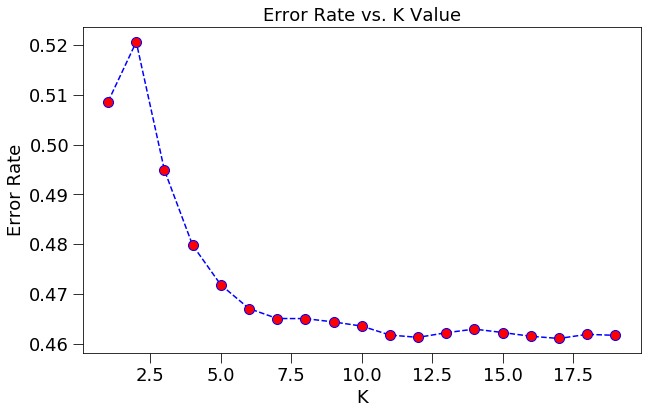

In [17]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Error Rate vs. K Value',fontsize=18)
plt.tick_params(axis='both',size=10, labelsize=18)
plt.xlabel('K',fontsize=18)
plt.ylabel('Error Rate',fontsize=18);


In [18]:
parameters = {'n_estimators':[500,600,700],
              'max_features':[3],
              'min_samples_leaf':[3,4]}
model = RandomForestClassifier()
grid_search = GridSearchCV(model, parameters, n_jobs=-2, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 out of  18 | elapsed:  6.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [19]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [96]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [97]:
boost=xgb.XGBRegressor(n_esrimators=700, max_features=3, min_samples_leaf=3, min_samples_split=2,)

In [98]:
boost.fit(X_train,y_train)

[01:04:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, max_features=3, min_child_weight=1,
             min_samples_leaf=3, min_samples_split=2, missing=None,
             n_esrimators=700, n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [99]:
y_pred_train=boost.predict(X_train)
y_pred_test=boost.predict(X_test)

In [100]:
RMSE=np.sqrt(mean_squared_error(y_test,y_pred_test))
RMSE

2.458435443375153

In [101]:
r2=r2_score(y_test,y_pred_test)
r2

0.2228290817707279

In [81]:
len(X_test)

49463

In [15]:
model=RandomForestClassifier(n_estimators=700,max_features=3,min_samples_leaf=3, min_samples_split=2,)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
model.score(X_test,y_test)

0.5894709176556213

In [87]:
model=RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
pred_y=model.predict(X_test)

In [18]:
cm=confusion_matrix(y_test,pred_y)
cm

array([[6597,   79,   18,  128,  262,    2,   63,   10,  563,   13,   14,
           3,   53],
       [ 288,  708,   18,   96,  876,    4,  207,   21,  743,   20,   32,
           1,  166],
       [  50,   35,  100,   40,  255,    2,   49,   12,  407,    7,    7,
           1,   43],
       [ 360,   88,   22, 1008,  751,    3,  111,   12,  421,   12,    8,
           2,   62],
       [ 227,  258,   37,  289, 8960,   14,  675,   58, 1277,   29,   38,
          11,  165],
       [  23,   23,    1,   21,  122,   81,   12,    2,   29,    0,    3,
           0,    2],
       [ 160,  127,   18,   52, 1433,    4, 2439,   84,  952,    9,   17,
           3,  129],
       [  42,   36,   17,   23,  393,    3,  136,  161,  227,    7,    9,
           2,   57],
       [ 646,  358,   85,  273, 1848,   13,  474,   61, 6401,   49,   36,
           3,  479],
       [  50,   32,    3,   12,  113,    1,   38,   12,   93,  219,    2,
           1,    7],
       [  77,   57,    7,   26,  271,    1,   37, 

In [19]:
model=SVC()

In [20]:
model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [21]:
model.score(X_train,y_train)

0.7061371966277045

In [22]:
model.fit(X_tr,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [23]:
model.score(X_tr,y_train)

0.47695626933307916

# Predict fire class / fire severity

In [67]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
df1['STAT_CAUSE_DESCR'] = enc.fit_transform(df1['STAT_CAUSE_DESCR'])
df1['FIRE_SIZE_CLASS'] = enc.fit_transform(df1['FIRE_SIZE_CLASS'])
df1['STATE'] = enc.fit_transform(df1['STATE'])
X = df1[['FIRE_YEAR','STATE', 'LATITUDE','LONGITUDE','STAT_CAUSE_DESCR']]
y = df1['FIRE_SIZE_CLASS']

In [68]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [69]:
from sklearn.metrics import classification_report,accuracy_score  
print("Classification Report")
print(classification_report(y_test,y_pred))  
print("Score for Naive Baye's:",model.score(X_train, y_train))
print("Accuracy score:",accuracy_score(y_test,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.66      0.65     14813
           1       0.55      0.66      0.60     14012
           2       0.00      0.00      0.00      3314
           3       0.00      0.00      0.00       433
           4       0.00      0.00      0.00       202
           5       0.00      0.00      0.00       114
           6       0.14      0.40      0.21        87

    accuracy                           0.58     32975
   macro avg       0.19      0.25      0.21     32975
weighted avg       0.51      0.58      0.55     32975

Score for Naive Baye's: 0.5756222564234755
Accuracy score: 0.5814404852160728


# predict fire cause

In [70]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
df1['STAT_CAUSE_DESCR'] = enc.fit_transform(df1['STAT_CAUSE_DESCR'])
df1['FIRE_SIZE_CLASS'] = enc.fit_transform(df1['FIRE_SIZE_CLASS'])
df1['STATE'] = enc.fit_transform(df1['STATE'])
X = df1[['FIRE_YEAR','STATE', 'LATITUDE','LONGITUDE','FIRE_SIZE_CLASS']]
y = df1['STAT_CAUSE_DESCR']

In [71]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [72]:
from sklearn.metrics import classification_report,accuracy_score  
print("Classification Report")
print(classification_report(y_test,y_pred))  
print("Score for Naive Baye's:",model.score(X_train, y_train))
print("Accuracy score:",accuracy_score(y_test,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.33      0.01      0.02      3602
           1       0.00      0.00      0.00      1865
           2       0.00      0.00      0.00       747
           3       0.41      0.79      0.54      8066
           4       0.00      0.00      0.00      2124
           5       0.00      0.00      0.00       350
           6       0.40      0.53      0.46      5252
           7       0.38      0.30      0.33      7124
           8       0.33      0.66      0.44      2349
           9       0.00      0.00      0.00       449
          10       0.00      0.00      0.00       212
          11       0.00      0.00      0.00       685
          12       0.00      0.00      0.00       150

    accuracy                           0.39     32975
   macro avg       0.14      0.18      0.14     32975
weighted avg       0.30      0.39      0.31     32975

Score for Naive Baye's: 0.38822887209152457
Accuracy scor